In [4]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


#Tm

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from asodesigner.consts import *

aso_pred_df = pd.read_csv(DATA_PATH / 'data_from_article_fixed.csv')
aso_pred_df.drop(['ISIS','Target_gene','Smiles'], axis=1, inplace=True)
aso_pred_df['Cell_line'] = aso_pred_df['Cell_line'].replace('A-431', 'A431')
aso_pred_df = aso_pred_df.dropna(subset=['Inhibition(%)','Density(cells/well)','Transfection'])

In [21]:
def calc_tm_14nt(bases_counter):
  return 64.9 + 41.0*((bases_counter['G']+bases_counter['C']-16.4)/(bases_counter['G']+bases_counter['C'] +bases_counter['A']+bases_counter['T']))
def calc_tm_13nt(bases_counter):
  return (bases_counter['A']+bases_counter['T'])*2 + (bases_counter['G']+bases_counter['C'])*4
def calc_tm(seq):
  seq_upper = seq.upper()
  bases_counter ={nt :seq_upper.count(nt) for nt in "ATGC"}
  if len(seq)>13:
    return calc_tm_14nt(bases_counter)
  else:
    return calc_tm_13nt(bases_counter)
aso_pred_df['Tm']  = aso_pred_df['Sequence'].apply(calc_tm)

In [22]:
def plot_grouped_feature_distribution(
    df, col_to_group, feature, score,
    top_quantile=0.5, max_cols_in_plot=20, min_group_size=100
):
    df = df.copy()
    df['group'] = df[col_to_group].astype(str).agg('-'.join, axis=1)

    group_thresholds = df.groupby('group')[score].quantile(top_quantile)
    df['group_threshold'] = df['group'].map(group_thresholds)

    df['color'] = np.where(df[score] >= df['group_threshold'], 'green', 'red')

    group_sizes = df['group'].value_counts()
    valid_groups = group_sizes[group_sizes >= min_group_size].index
    df = df[df['group'].isin(valid_groups)]

    group_names = sorted(df['group'].unique())
    num_groups = len(group_names)

    for i in range(0, num_groups, max_cols_in_plot):
        chunk = group_names[i:i + max_cols_in_plot]
        chunk_df = df[df['group'].isin(chunk)].copy()

        if chunk_df.empty:
            continue

        chunk_df['x_pos'] = chunk_df['group'].apply(lambda g: chunk.index(g))
        chunk_with_size = [
            f"{ch}_{group_sizes[ch]}" for ch in chunk
        ]

        fig, ax = plt.subplots(figsize=(max(10, len(chunk) * 0.6), 6))

        ax.scatter(chunk_df['x_pos'], chunk_df[feature], c=chunk_df['color'], alpha=0.7)
        ax.set_xticks(range(len(chunk)))
        ax.set_xticklabels(chunk_with_size, rotation=90)
        ax.set_xlabel("Groups")
        ax.set_ylabel(feature)
        ax.set_title(
            f"{feature} per Group (Groups {i + 1}–{i + len(chunk)})\n"
            f"Threshold = Top {int(top_quantile*100)}% scores in each group"
        )
        ax.grid(True, axis='y', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()


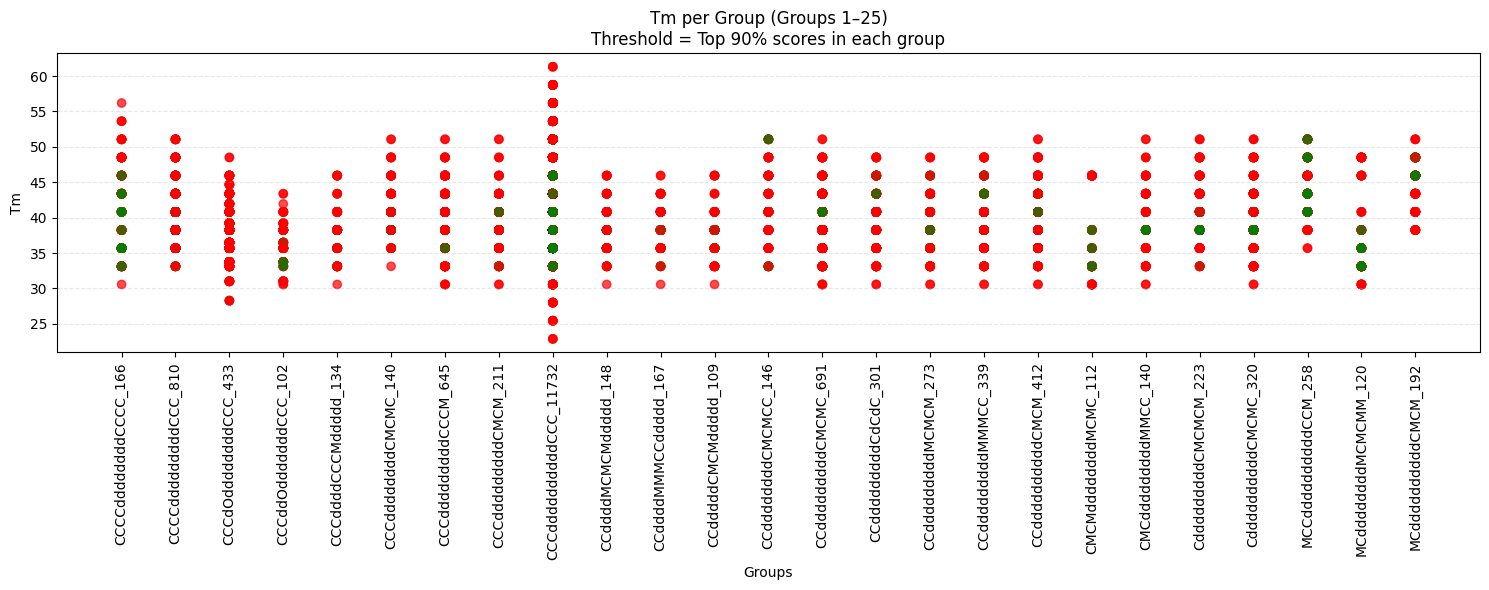

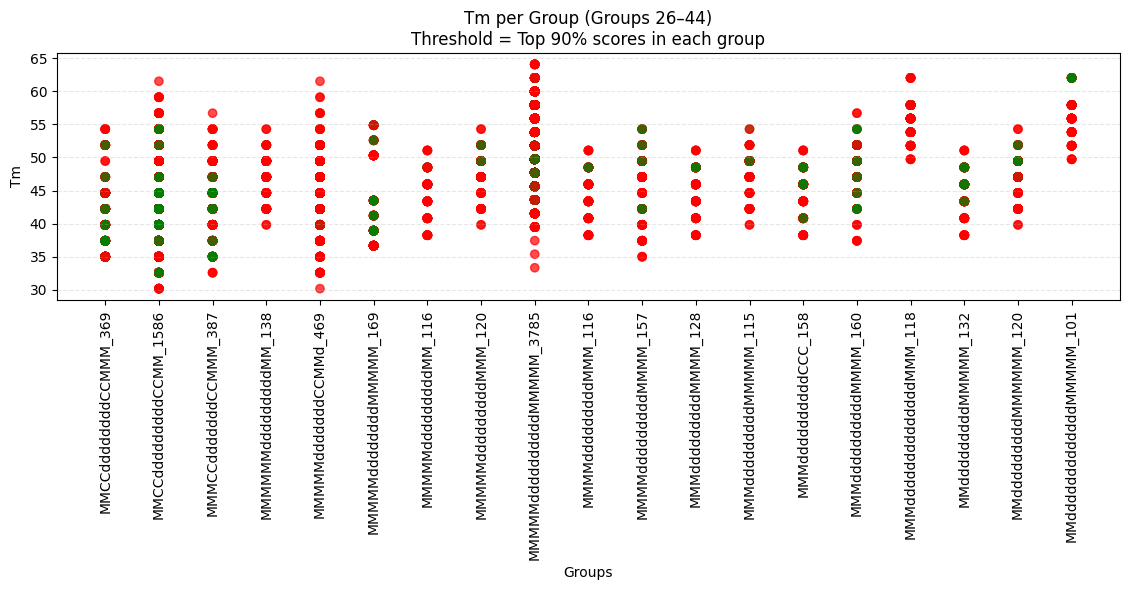

In [23]:
col_groups = ['Chemical_Pattern']
import numpy as np
plot_grouped_feature_distribution(
    df=aso_pred_df,
    col_to_group=col_groups,
    feature='Tm',
    score='Inhibition(%)',
    top_quantile=0.9,
    max_cols_in_plot=25,
    min_group_size= 100
)


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

groups = ['A', 'B', 'C', 'D']
sweet_spots = {
    'A': (0, 2),
    'B': (3, 5),
    'C': (6, 8),
    'D': (8, 10)
}

data = []
n = 10000

for group in groups:
    feature = np.random.uniform(0, 10, n)
    low_noise = np.random.normal(30, 0, n)
    high_noise = np.random.normal(1000, 0, n)

    sweet_start, sweet_end = sweet_spots[group]
    in_sweet_spot = (feature >= sweet_start) & (feature <= sweet_end)
    score = np.where(in_sweet_spot, high_noise, low_noise)

    df_group = pd.DataFrame({
        'group': group,
        'feature': feature,
        'score': score
    })
    data.append(df_group)

df = pd.concat(data).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)

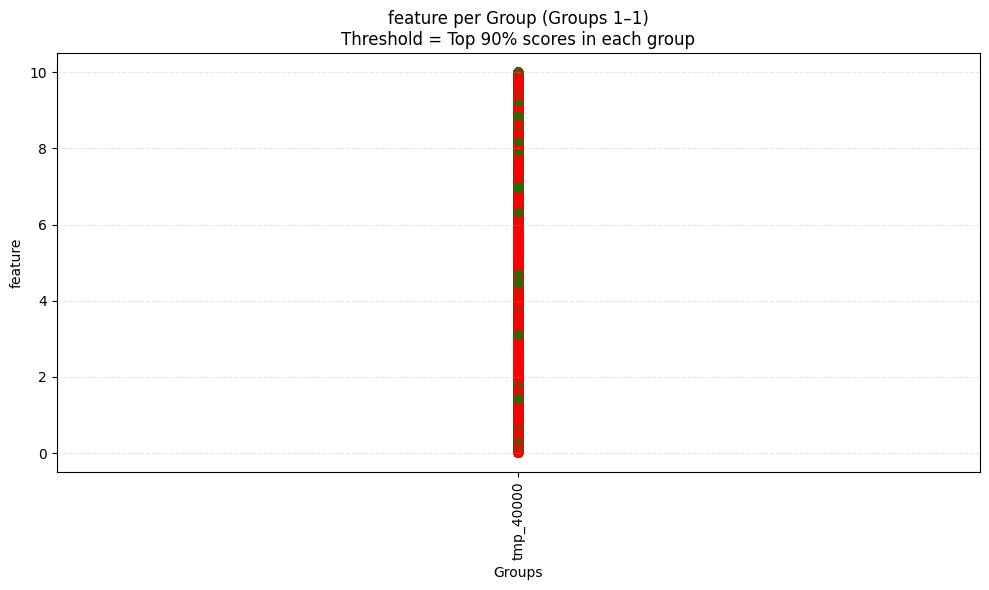

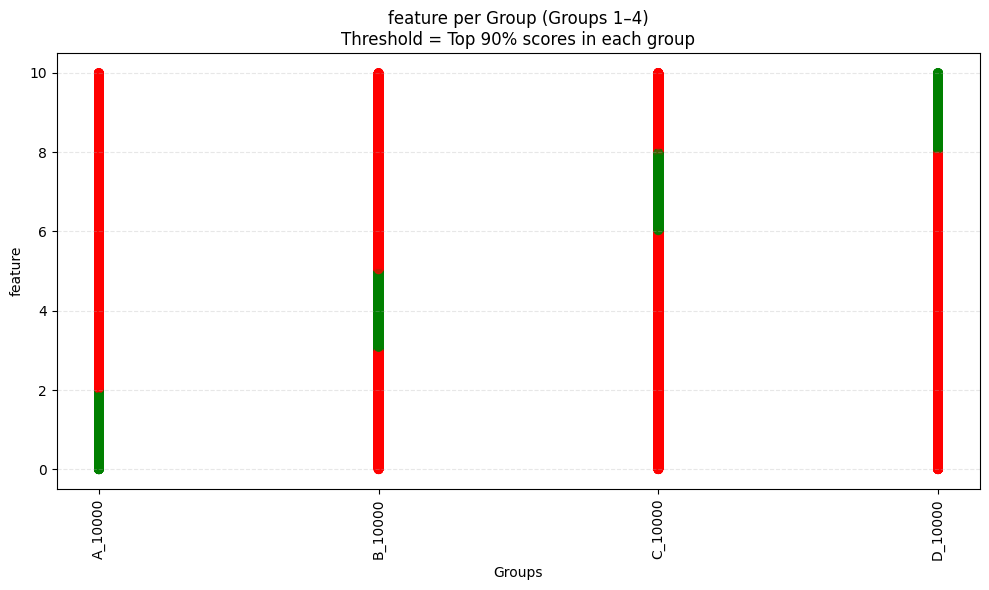

In [27]:
df['tmp'] = 'tmp'
import numpy as np
for col in ['tmp','group']:
  plot_grouped_feature_distribution(
      df=df,
      col_to_group=[col],
      feature='feature',
      score='score',
      top_quantile=0.9,
      max_cols_in_plot=25  # Show up to 15 groups per plot
  )
